In [2]:
# 查看top300_20_23_1681699961594.txt文件中的数据格式
import pandas as pd

file = './data/top300_20_23log/top300_20_23_1681699961594.txt'
chunks = pd.read_csv(file, chunksize=1000)
result = set()
for chunk in chunks:
    for _, row in chunk.iterrows():
        repo_license = row[61]
        repo_name = row[6]
        if repo_license not in ['', '0', ' ', 0, 'nan', None] and pd.isna(repo_license) == False:
            # print(f'{repo_name}: {repo_license}')
            result.add((repo_name, repo_license))
with open('extracted_license.txt', "w") as file:
    for item in result:
        file.write(str(item) + "\n")

In [96]:
from pandas import DataFrame
import os, json

df = DataFrame(columns=['org_name', 'repo_name', 'license', 'star_num', 'fork_num'])
i = 0
with open('extracted_license.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()
    for line in lines:
        value = eval(line)
        org_name = value[0].split('/')[0]
        repo_name = value[0].split('/')[1]
        license = value[1]
        star_num = None
        fork_num = None
        # 读取star数
        star_path = f'./data/top_300_metrics/{org_name}/{repo_name}/stars.json'
        if os.path.exists(star_path):
            with open(star_path, 'r', encoding='utf-8') as file:
                result = json.load(file)
                max_date = max(result.keys())
                star_num = result[max_date]
        # 读取fork数
        fork_path = f'./data/top_300_metrics/{org_name}/{repo_name}/technical_fork.json'
        if os.path.exists(fork_path):
            with open(fork_path, 'r', encoding='utf-8') as file:
                result = json.load(file)
                max_date = max(result.keys())
                fork_num = result[max_date]
        df.loc[i] = [org_name, repo_name, license, star_num, fork_num]
        i += 1
# 删除重复项
df.drop_duplicates(subset=['org_name', 'repo_name', 'license'], keep='first', inplace=True)
df = df[~((df.duplicated(subset=['org_name', 'repo_name'], keep=False)) & (df['license'] == 'Other'))]
df.to_csv('extracted_license.csv', index=False)

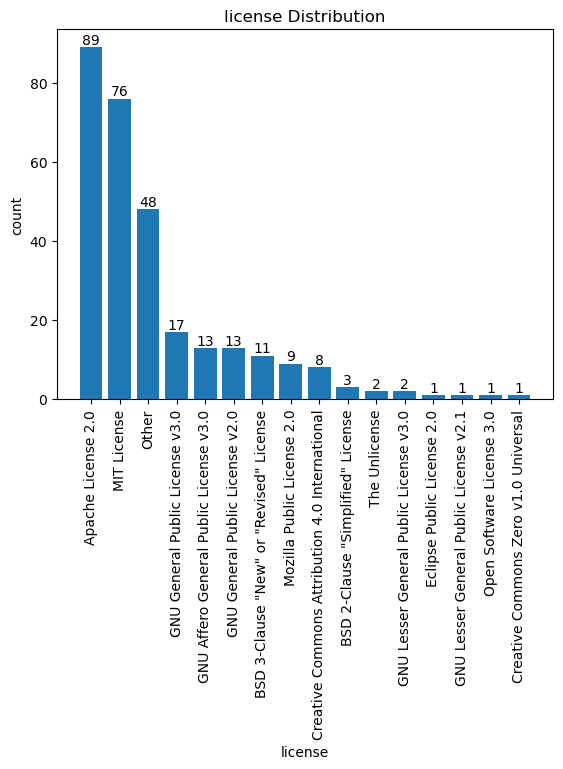

In [10]:
import matplotlib.pyplot as plt

license_count = df['license'].value_counts()

plt.bar(license_count.index, license_count.values)
plt.xlabel('license')
plt.ylabel('count')
plt.title('license Distribution')
plt.xticks(rotation=90)
for i, count in enumerate(license_count.values):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()

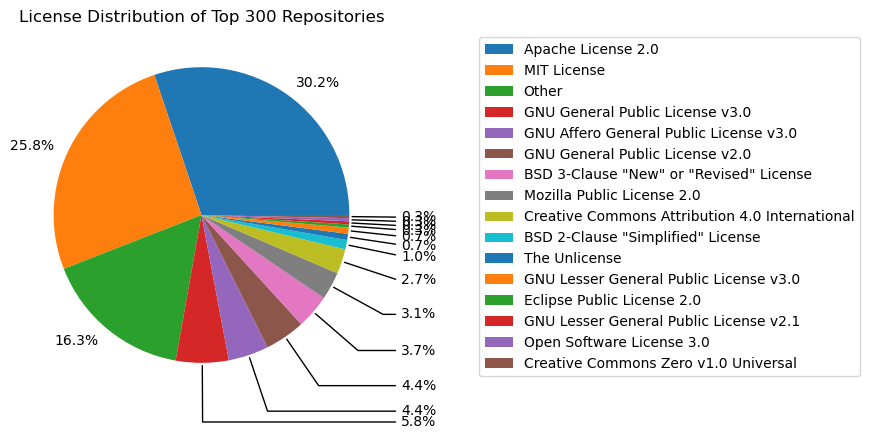

In [86]:
import numpy as np

license_count = df['license'].value_counts()

# 假设你有以下的数据
labels = license_count.index
sizes = license_count.values

# 计算每个区域的占比
percent = [i/sum(sizes) for i in sizes]

# 准备标签列表
inner_labels = ['' if p < 0.10 else f'{p*100:.1f}%' for p in percent]
outer_labels = ['' if p >= 0.10 else f'{p*100:.1f}%' for p in percent]

# 创建饼图
fig, ax = plt.subplots(1,1)
wedges, text = ax.pie(sizes, labels=inner_labels)
ax.legend(wedges, labels, loc="upper right", bbox_to_anchor=(1.8, 0, 0.5, 1))

# 添加外部引导线和标签
kw = dict(arrowprops=dict(arrowstyle="-"), zorder=0, va="center")
for i, p in enumerate(percent):
    if p < 0.10:
        ang = (ax.patches[i].theta2 - ax.patches[i].theta1) / 2. + ax.patches[i].theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(outer_labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                     **kw)
plt.title('License Distribution of Top 300 Repositories')
plt.show()

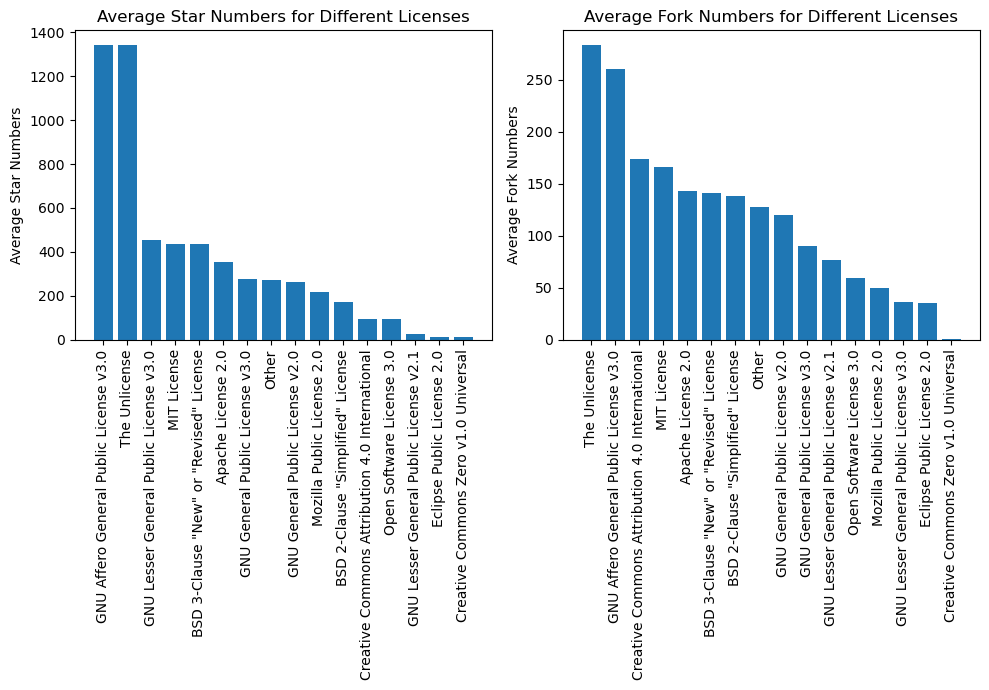

In [111]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7))

# 创建star_num的条形图
star_values = df.groupby('license')[['star_num']].mean().sort_values(by='star_num', ascending=False)
index = np.arange(len(star_values))

# 创建star_num的条形图
bar1 = axs[0].bar(index, star_values['star_num'], label='Star Num')
axs[0].set_xticks(index)
axs[0].set_xticklabels(star_values.index, rotation='vertical') # rotation参数用于旋转标签，使其更容易阅读
axs[0].set_ylabel('Average Star Numbers')
axs[0].set_title('Average Star Numbers for Different Licenses')

fork_values = df.groupby('license')[['fork_num']].mean().sort_values(by='fork_num', ascending=False)
bar1 = axs[1].bar(index, fork_values['fork_num'], label='Fork Num')
axs[1].set_xticks(index)
axs[1].set_xticklabels(fork_values.index, rotation='vertical') # rotation参数用于旋转标签，使其更容易阅读
axs[1].set_ylabel('Average Fork Numbers')
axs[1].set_title('Average Fork Numbers for Different Licenses')

# 显示图形
plt.tight_layout()
plt.show()